#### https://www.kaggle.com/code/shivamb/3d-convolutions-understanding-use-case
# implementation of MNIST3D classification with conv3D laer

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hajarhesham","key":"67e84a21479743949f97c093059149bb"}'}

In [ ]:
%mkdir ~/.kaggle

In [ ]:
%cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                 5MB  2022-11-13 15:47:17          13220        373  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india    Credit Card Spending Habits in India           319KB  2022-12-14 07:30:37            767         32  1.0              
michals22/coffee-dataset                                        Coffee dataset                                  24KB  2022-12-15 20:02:12           2877         72  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce Sales Data

In [ ]:
!kaggle datasets download -d daavoo/3d-mnist

 98% 149M/153M [00:06<00:00, 29.8MB/s]
100% 153M/153M [00:06<00:00, 25.6MB/s]


In [ ]:
!unzip /content/3d-mnist.zip

Archive:  /content/3d-mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


In [ ]:
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta,SGD,Adam
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from tensorflow.keras.models import Model
import numpy as np
import tensorflow.keras
import h5py
from tensorflow import keras

# init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
with h5py.File('full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [ ]:
print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)

print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


In [ ]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])
## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
xtrain.shape

(10000, 16, 16, 16, 3)

In [ ]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',strides = 1,padding='same')(input_layer)
conv_layer1  = BatchNormalization()(conv_layer1)
conv_layer2 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',strides = 1,padding='same')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',strides = 1,padding='same')(pooling_layer1)
conv_layer3  = BatchNormalization()(conv_layer3)
conv_layer4 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu',strides = 1,padding='same')(conv_layer3)
conv_layer4  = BatchNormalization()(conv_layer4)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = Dropout(0.25)(pooling_layer2)

flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 1024 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=4096, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.44)(dense_layer1)
dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.45)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)
## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 16, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 16, 16, 16, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 32)    13856     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 8, 8, 32)      0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 8, 8, 64)       55360 

In [ ]:
1model.compile(loss=categorical_crossentropy, optimizer=Adadelta(learning_rate =.01), metrics=['acc'])
history = model.fit(x=xtrain, y=y_train, batch_size=32, epochs=50, validation_split=0.3)

Epoch 1/50
219/219 [==============================] - 12s 36ms/step - loss: 3.4886 - acc: 0.1687 - val_loss: 2.2968 - val_acc: 0.1147
Epoch 2/50
219/219 [==============================] - 8s 36ms/step - loss: 2.3614 - acc: 0.2609 - val_loss: 1.8414 - val_acc: 0.4283
Epoch 3/50
219/219 [==============================] - 7s 34ms/step - loss: 2.0893 - acc: 0.3174 - val_loss: 1.6180 - val_acc: 0.5070
Epoch 4/50
219/219 [==============================] - 7s 34ms/step - loss: 1.9121 - acc: 0.3739 - val_loss: 1.4822 - val_acc: 0.5313
Epoch 5/50
219/219 [==============================] - 7s 34ms/step - loss: 1.7936 - acc: 0.4084 - val_loss: 1.4066 - val_acc: 0.5510
Epoch 6/50
219/219 [==============================] - 8s 36ms/step - loss: 1.6972 - acc: 0.4429 - val_loss: 1.3583 - val_acc: 0.5537
Epoch 7/50
219/219 [==============================] - 7s 34ms/step - loss: 1.5945 - acc: 0.4724 - val_loss: 1.2943 - val_acc: 0.5817
Epoch 8/50
219/219 [==============================] - 8s 36ms/step -

In [ ]:
pred = model.predict(xtest)

63/63 [==============================] - 1s 9ms/step


In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
pred[1]

7

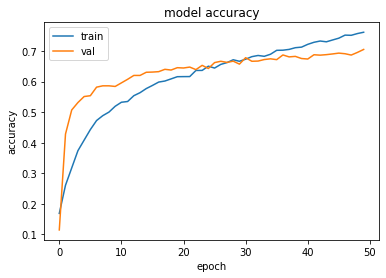

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

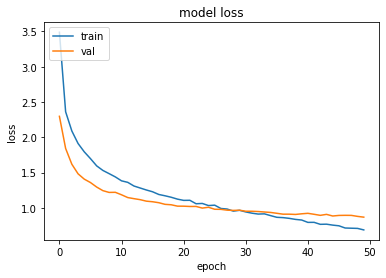

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()